# EECS 731 Climate Changes

**Author: Likitha Vemulapalli<br>
Date: 11-23-2020 <br>
M.S in Computer Science <br>
University of Kansas**

# Classification of Temperature and Conditions in Russia

# Importing Libraries

In [1]:
#importing required libraries
import pandas as pd
import numpy as np

#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For Cross-Validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#For Classifier models
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

# Importing the data

In [2]:
df = pd.read_csv('russia.csv')
df.head()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,russia,01/01/1970,10.1,-2.1,4.7,-19.7,NaN,0.0,NaN,13.9,NaN,6.2,48.3,84.54,Partially cloudy
1,russia,01/02/1970,19.1,-3.9,10.4,-14.6,NaN,0.0,NaN,18.3,NaN,3.1,87.5,89.14,Overcast
2,russia,01/03/1970,28.1,20.9,25.5,7.9,NaN,0.0,NaN,18.3,NaN,3.7,92.5,91.09,Overcast
3,russia,01/04/1970,26.9,20.9,22.7,6.9,NaN,0.0,NaN,16.1,NaN,3.7,97.5,89.49,Overcast
4,russia,01/05/1970,32.1,28.1,29.5,18.2,NaN,0.0,NaN,16.1,NaN,2.7,100.0,92.43,Overcast


In [3]:
#dropping the columns that are not required for classification
df = df.drop(columns = ['Name', 'Date time'])

In [4]:
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,10.1,-2.1,4.7,-19.7,NaN,0.0,NaN,13.9,NaN,6.2,48.3,84.54,Partially cloudy
1,19.1,-3.9,10.4,-14.6,NaN,0.0,NaN,18.3,NaN,3.1,87.5,89.14,Overcast
2,28.1,20.9,25.5,7.9,NaN,0.0,NaN,18.3,NaN,3.7,92.5,91.09,Overcast
3,26.9,20.9,22.7,6.9,NaN,0.0,NaN,16.1,NaN,3.7,97.5,89.49,Overcast
4,32.1,28.1,29.5,18.2,NaN,0.0,NaN,16.1,NaN,2.7,100.0,92.43,Overcast


To remove the redundancy in the Conditions, I seperated the text based on the comma and created new column to predict the Conditions

In [5]:
df["Conditions"]= df["Conditions"].str.split(",", n = 1, expand = True) 

In [6]:
#checking for the null values
df.isnull().sum()

Maximum Temperature        0
Minimum Temperature        0
Temperature                0
Wind Chill              4957
Heat Index             17141
Precipitation              0
Snow Depth             12669
Wind Speed                 0
Wind Gust              17186
Visibility                34
Cloud Cover                2
Relative Humidity          0
Conditions                 0
dtype: int64

Note: As we have huge number of null values in Wind Chill, Heat Index, Snow Depth and Wind Gust we are dropping these columns

In [7]:
#removing columns with most null values
df = df.drop(columns = ['Wind Chill', 'Heat Index', 'Snow Depth', 'Wind Gust'])

Fill out the missing null values

In [8]:
df = df.apply(lambda x : x.fillna(method = 'ffill', axis=0))

In [9]:
#checking for the null values
df.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
dtype: int64

In [10]:
#For classification, categorizing the temperature data into 3 categories
tg_labels = [1,2,3]
df['Russia_Temp_bins'] = pd.cut(df['Temperature'], 3, labels=tg_labels, include_lowest=True)


df_temp = df[['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 'Visibility', 'Relative Humidity', 'Russia_Temp_bins']]

df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Visibility,Relative Humidity,Russia_Temp_bins
0,10.1,-2.1,4.7,0.0,13.9,48.3,6.2,84.54,1
1,19.1,-3.9,10.4,0.0,18.3,87.5,3.1,89.14,2
2,28.1,20.9,25.5,0.0,18.3,92.5,3.7,91.09,2
3,26.9,20.9,22.7,0.0,16.1,97.5,3.7,89.49,2
4,32.1,28.1,29.5,0.0,16.1,100.0,2.7,92.43,2


Temperature is running value, so I splitted the temperature into three Classes - low, medium and high.

In [11]:
#low = (-32.319, 7.333]
#medium = (7.333, 46.867]
#high = (46.867, 86.4]

pd.cut(df['Temperature'], 3).head()

0    (-32.319, 7.333]
1     (7.333, 46.867]
2     (7.333, 46.867]
3     (7.333, 46.867]
4     (7.333, 46.867]
Name: Temperature, dtype: category
Categories (3, interval[float64]): [(-32.319, 7.333] < (7.333, 46.867] < (46.867, 86.4]]

In [12]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Visibility,Relative Humidity,Russia_Temp_bins
0,10.1,-2.1,4.7,0.0,13.9,48.3,6.2,84.54,1
1,19.1,-3.9,10.4,0.0,18.3,87.5,3.1,89.14,2
2,28.1,20.9,25.5,0.0,18.3,92.5,3.7,91.09,2
3,26.9,20.9,22.7,0.0,16.1,97.5,3.7,89.49,2
4,32.1,28.1,29.5,0.0,16.1,100.0,2.7,92.43,2


In [13]:
df_temp.isnull().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Precipitation          0
Wind Speed             0
Cloud Cover            0
Visibility             0
Relative Humidity      0
Russia_Temp_bins       0
dtype: int64

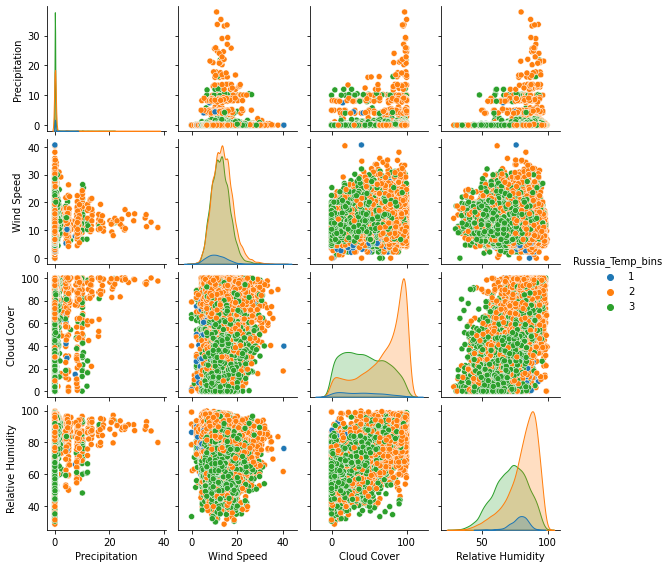

In [14]:
# Pair plot to get the distributions of temp_bins
pair_plot = sns.pairplot(df_temp, hue='Russia_Temp_bins',vars=['Precipitation', 'Wind Speed', 'Cloud Cover', 'Relative Humidity'], height=2)

Pair plots are simple way to visualize relationships between each variable.<br>
Here, we could see that precipitation has nothing much to do with temperature, we can drop  that column as it doesn't show much affect

# Classification of Temperature

In [15]:
df_temp.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Cloud Cover,Visibility,Relative Humidity,Russia_Temp_bins
0,10.1,-2.1,4.7,0.0,13.9,48.3,6.2,84.54,1
1,19.1,-3.9,10.4,0.0,18.3,87.5,3.1,89.14,2
2,28.1,20.9,25.5,0.0,18.3,92.5,3.7,91.09,2
3,26.9,20.9,22.7,0.0,16.1,97.5,3.7,89.49,2
4,32.1,28.1,29.5,0.0,16.1,100.0,2.7,92.43,2


In [16]:
#removing columns which are not required
df_temp = df_temp.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'Temperature', 'Precipitation'])

In [17]:
  df_temp.head()

,Wind Speed,Cloud Cover,Visibility,Relative Humidity,Russia_Temp_bins
0,13.9,48.3,6.2,84.54,1
1,18.3,87.5,3.1,89.14,2
2,18.3,92.5,3.7,91.09,2
3,16.1,97.5,3.7,89.49,2
4,16.1,100.0,2.7,92.43,2


For using cross validation, we divide the data into arrays specifically X having the features and y being the temperature column.

In [18]:
# Split-out dataset
array = df_temp.values
X = array[:,0:4]
print(X)
y = array[:,4]
print(y)


[[13.9  48.3   6.2  84.54]
 [18.3  87.5   3.1  89.14]
 [18.3  92.5   3.7  91.09]
 ...
 [15.9  93.4   5.7  86.2 ]
 [11.1  99.8   3.   97.14]
 [ 9.6  98.    3.4  95.67]]
[1. 2. 2. ... 2. 2. 2.]


In [19]:
# 10 fold cross validation

kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [21]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 67.31


In [22]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 58.47


In [23]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 12)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 66.16


In [24]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 66.05


In [25]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 68.01


In [26]:
#Comparing models to get the best suitable model

In [27]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Gaussian Naive Bayes,68.01
0,Linear SVC,67.31
2,KNN,66.16
3,Random Forest,66.05
1,Decision Tree,58.47


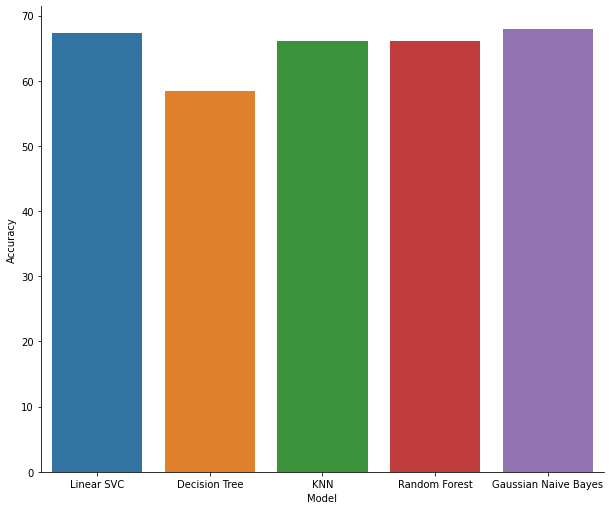

In [28]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

On comparing models, we observe that Guassian performed well rather than other models. There was not huge difference between Gaussian, KNN and Linear SVM.

# Classification of Conditions

In [29]:
## Classifying conditions

In [30]:
df_conditions = df.copy(deep=True)

In [31]:
df_conditions.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions,Russia_Temp_bins
0,10.1,-2.1,4.7,0.0,13.9,6.2,48.3,84.54,Partially cloudy,1
1,19.1,-3.9,10.4,0.0,18.3,3.1,87.5,89.14,Overcast,2
2,28.1,20.9,25.5,0.0,18.3,3.7,92.5,91.09,Overcast,2
3,26.9,20.9,22.7,0.0,16.1,3.7,97.5,89.49,Overcast,2
4,32.1,28.1,29.5,0.0,16.1,2.7,100.0,92.43,Overcast,2


In [32]:
df_conditions.shape

(18019, 10)

In [33]:
#removing columns which are not required
df_conditions = df_conditions.drop(columns = ['Maximum Temperature', 'Minimum Temperature', 'Russia_Temp_bins'])

In [34]:
df_conditions.isnull().sum()

Temperature          0
Precipitation        0
Wind Speed           0
Visibility           0
Cloud Cover          0
Relative Humidity    0
Conditions           0
dtype: int64

In [35]:
df_conditions.describe()

,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity
count,18019.000000,18019.000000,18019.000000,18019.000000,18019.000000,18019.000000
mean,41.900538,0.193614,13.101970,5.165109,57.619085,76.815531
std,19.042177,1.424943,4.309671,1.332243,31.143436,12.660044
min,-32.200000,0.000000,0.000000,0.000000,0.000000,28.430000
25%,28.800000,0.000000,10.100000,4.400000,30.900000,68.630000
50%,41.600000,0.000000,12.800000,5.700000,61.800000,79.020000
75%,58.200000,0.020000,15.700000,6.200000,86.400000,86.750000
max,86.400000,37.920000,40.600000,9.600000,100.000000,99.710000


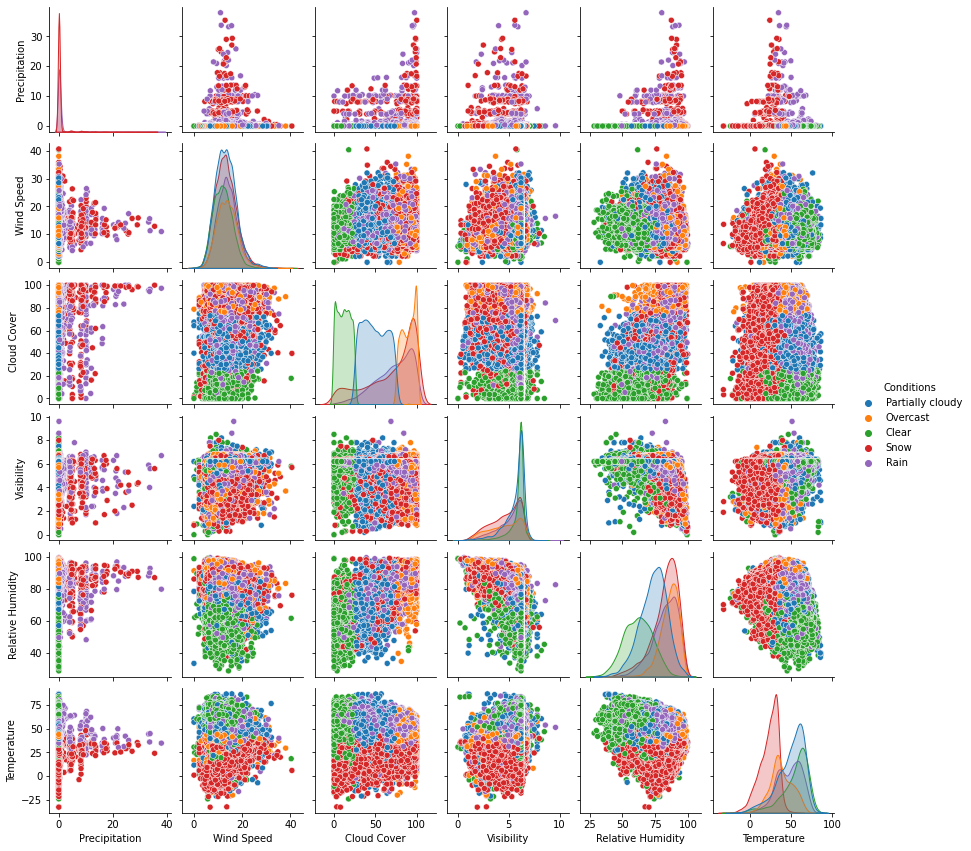

In [36]:
# Pair plot to get the distributions of Conditions
import warnings
warnings.simplefilter('ignore')
pair_plot = sns.pairplot(df_conditions, hue='Conditions',vars=['Precipitation', 'Wind Speed','Cloud Cover', 'Visibility', 'Relative Humidity', 'Temperature'], height=2)

When you observe the plot, precipitation shows slight variation unlike when considered for temperature. So, we will use that feature for classifying conditions.

In [37]:
df_conditions.head()

,Temperature,Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,4.7,0.0,13.9,6.2,48.3,84.54,Partially cloudy
1,10.4,0.0,18.3,3.1,87.5,89.14,Overcast
2,25.5,0.0,18.3,3.7,92.5,91.09,Overcast
3,22.7,0.0,16.1,3.7,97.5,89.49,Overcast
4,29.5,0.0,16.1,2.7,100.0,92.43,Overcast


For using cross validation, we divide the data into arrays specifically X having the features and y being the temperature column.

In [38]:
# Split-out dataset
array = df_conditions.values
X = array[:,0:6]
print(X)
y = array[:,6]
print(y)


[[4.7 0.0 13.9 6.2 48.3 84.54]
 [10.4 0.0 18.3 3.1 87.5 89.14]
 [25.5 0.0 18.3 3.7 92.5 91.09]
 ...
 [41.4 0.0 15.9 5.7 93.4 86.2]
 [41.7 0.0 11.1 3.0 99.8 97.14]
 [43.9 0.0 9.6 3.4 98.0 95.67]]
['Partially cloudy' 'Overcast' 'Overcast' ... 'Overcast' 'Overcast'
 'Overcast']


In [39]:
# 10 fold cross validation

kf = KFold(n_splits=10, random_state=None, shuffle=False)

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [41]:
#1. Linear SVM

ypred_outputs_SVC = []
yrandom_outputs_SVC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = SVC(kernel='linear')
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_SVC.append(ypred)
    yrandom_outputs_SVC.append(ytest)

pSVCtotal = np.concatenate(ypred_outputs_SVC)
ySVCtotal = np.concatenate(yrandom_outputs_SVC)


acc_svc = round((accuracy_score(ySVCtotal, pSVCtotal)*100), 2)

print('Accuracy for SVC:', acc_svc)

Accuracy for SVC: 63.25


In [42]:
#2. Decision Tree Classifier

ypred_outputs_DT = []
yrandom_outputs_DT = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_DT.append(ypred)
    yrandom_outputs_DT.append(ytest)

pDTtotal = np.concatenate(ypred_outputs_DT)
yDTtotal = np.concatenate(yrandom_outputs_DT)


acc_dt = round((accuracy_score(yDTtotal, pDTtotal)*100), 2)

print('Accuracy for Decision Tree Classifier:', acc_dt)

Accuracy for Decision Tree Classifier: 78.23


In [43]:
#3. KNN Classifier

ypred_outputs_KNN = []
yrandom_outputs_KNN = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = KNeighborsClassifier(n_neighbors = 5)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_KNN.append(ypred)
    yrandom_outputs_KNN.append(ytest)

pKNNtotal = np.concatenate(ypred_outputs_KNN)
yKNNtotal = np.concatenate(yrandom_outputs_KNN)


acc_knn = round((accuracy_score(yKNNtotal, pKNNtotal)*100), 2)

print('Accuracy for KNN Classifier:', acc_knn)

Accuracy for KNN Classifier: 59.86


In [44]:
#4. Random Forest Classifier

ypred_outputs_RF = []
yrandom_outputs_RF = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_RF.append(ypred)
    yrandom_outputs_RF.append(ytest)

pRFtotal = np.concatenate(ypred_outputs_RF)
yRFtotal = np.concatenate(yrandom_outputs_RF)


acc_rf = round((accuracy_score(yRFtotal, pRFtotal)*100), 2)

print('Accuracy for Random Forest Classifier:', acc_rf)

Accuracy for Random Forest Classifier: 81.91


In [45]:
#5. Gaussian NB

ypred_outputs_NBC = []
yrandom_outputs_NBC = []

for train_index, test_index in kf.split(X,y):
    xtrain,xtest,ytrain,ytest=X[train_index],X[test_index],y[train_index],y[test_index]
    model = GaussianNB()
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    ypred_outputs_NBC.append(ypred)
    yrandom_outputs_NBC.append(ytest)

pNBCtotal = np.concatenate(ypred_outputs_NBC)
yNBCtotal = np.concatenate(yrandom_outputs_NBC)


acc_gaussian = round((accuracy_score(yNBCtotal, pNBCtotal)*100), 2)

print('Accuracy for Gaussian NB:', acc_gaussian)

Accuracy for Gaussian NB: 76.82


In [46]:
#Comparing models to get the best suitable model

In [47]:
models = pd.DataFrame({
    'Model': ['Linear SVC', 'Decision Tree','KNN', 'Random Forest', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_dt, acc_knn, acc_rf, acc_gaussian]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,Random Forest,81.91
1,Decision Tree,78.23
4,Gaussian Naive Bayes,76.82
0,Linear SVC,63.25
2,KNN,59.86


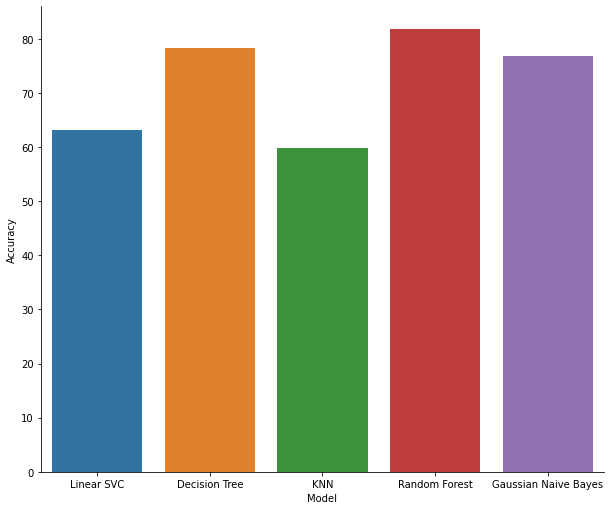

In [48]:
sns.catplot(data=models, y='Accuracy',x='Model',kind='bar',height=7,aspect=1.2)

We can see clearly that Decision Tree and Random Forest Classifiers performed pretty good on predicting the test data accurately.